# Example 1. Hand-Written Digit Recognition on MNIST using Tensorflow

In [94]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
from tensorflow.examples.tutorials import mnist
import tensorflow as tf

##### Load data

In [10]:
data = mnist.input_data.read_data_sets('MNIST_data/', one_hot=True,)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


##### Define network architecture

In [159]:
input_size = 28*28
num_classes = 10
hidden_units = 256
dropout = 0.5

In [160]:
x_data = tf.placeholder(tf.float32, [None, input_size])
y_data = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)


def network(input_data, hidden_units, input_size, output_size, init_mean=0, init_std=0.1):
    '''
    Forward pass thru a fully connected network
    '''
    if isinstance(hidden_units, int):
        weights_hidden = tf.Variable(tf.truncated_normal([input_size, hidden_units], mean=0, stddev=0.1))
        biases_hidden = tf.Variable(tf.truncated_normal([hidden_units], mean=0, stddev=0.1))
        hidden = tf.nn.relu(tf.matmul(x_data, weights_hidden) + biases_hidden)
        hidden = tf.nn.dropout(hidden, keep_prob)
        weights_output = tf.Variable(tf.zeros([hidden_units, num_classes]))
        biases_output = tf.Variable(tf.zeros([num_classes]))
        logits = tf.nn.softmax(tf.matmul(hidden, weights_output) + biases_output)
    elif isinstance(hidden_units, (list, tuple)):
        hidden_units.insert(0, input_size)
        for u_in,u_out in zip(hidden_units[:-1], hidden_units[1:]):
            weights_hidden = tf.Variable(tf.truncated_normal([u_in, u_out], mean=init_mean, stddev=init_std))
            biases_hidden = tf.Variable(tf.truncated_normal([u_out], mean=init_mean, stddev=init_std))
            input_data = tf.matmul(input_data, weights_hidden) + biases_hidden
            input_data = tf.nn.dropout(input_data, keep_prob)
        weights_output = tf.Variable(tf.zeros([hidden_units[-1], num_classes]))
        biases_output = tf.Variable(tf.zeros([num_classes]))
        logits = tf.nn.softmax(tf.matmul(input_data, weights_output) + biases_output)            
    else:
        raise Exception('Hidden units argument must be int or list/tuple')
    return logits
    
logits = network(x_data, hidden_units, input_size, num_classes)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_data, logits=logits))
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

correct = tf.equal(tf.argmax(y_data, 1), tf.argmax(logits, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

##### Train the net

In [161]:
steps = 10000
batch_size = 100

In [162]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [163]:
metrics = {
    'step': [],
    'score': [],
    'val_score': [],
    'loss': [],
    'val_loss': [],
}

for i in range(steps):
    metrics['step'].append(i)
    x_batch, y_batch = data.train.next_batch(batch_size)
    l,_ = sess.run([loss, optimizer], 
                   feed_dict={x_data: x_batch, y_data: y_batch, keep_prob: dropout})
    acc = sess.run(accuracy, 
                   feed_dict={x_data: x_batch, y_data: y_batch, keep_prob: 1.})
    metrics['score'].append(acc), metrics['loss'].append(l)
    val_l, val_acc = sess.run([loss, accuracy], 
                              feed_dict={x_data: data.validation.images, y_data: data.validation.labels, keep_prob: 1.})
    metrics['val_score'].append(val_acc), metrics['val_loss'].append(val_l)

##### Evaluate

In [164]:
acc = sess.run(accuracy, feed_dict={x_data: data.test.images, y_data: data.test.labels, keep_prob: 1.})

print('Accuracy after %d steps: %s' % (steps, acc))

Accuracy after 10000 steps: 0.97


In [165]:
def plot_learning_curve(metrics, fig_shape=(12,4)):
    '''
    Plots learning curve for loss and score both for train and validation
    -------
    :metrics is a dict with following keys: ['step', 'val_loss', 'loss', 'val_score', 'score'], where values are lists
    '''
    plt.figure(figsize=fig_shape)
    plt.subplot(121)
    plt.title('Loss curves')
    plt.plot(metrics['step'], metrics['loss'], 'r--', label='train loss')
    plt.plot(metrics['step'], metrics['val_loss'], 'b--', label='validation loss')
    plt.legend()
    plt.subplot(122)
    plt.title('Score curves')
    plt.plot(metrics['step'], metrics['score'], 'r--', label='train score')
    plt.plot(metrics['step'], metrics['val_score'], 'b--', label='validation score')
    plt.legend()
    plt.show()

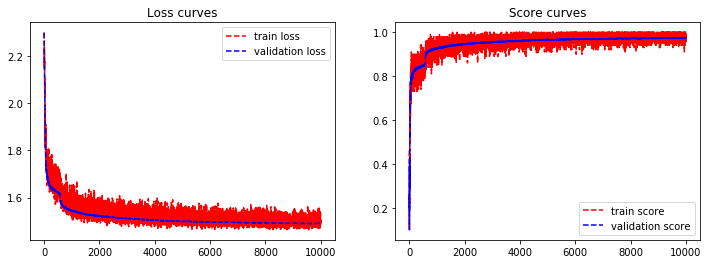

In [166]:
plot_learning_curve(metrics)

#### Model architecture report

|steps|hidden units|accuracy|
|---|---|---|
|10000|0|0.92|
|10000|[100]|0.962|
|10000|[100,50]|0.88|
|10000|[256,128]|0.8915|
|10000|[512,256,128]| no convergence |
|10000|256| **0.97**|